In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.preprocessing import Imputer
from sklearn.metrics import euclidean_distances, mean_absolute_error
from scipy.stats import skew, norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import repeat
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from matplotlib_venn import venn2, venn3
from sklearn.preprocessing import LabelEncoder

import sys
sys.path.append('../gpn_test/crm/')
sys.path.append('../gpn_test/oil/')

import importlib
import CRM_base as crm
import fc_oil as oil

In [2]:
df_train = pd.read_csv('input/prepared_data/train_proc.csv',  
                       parse_dates = ['Дата'])
df_test_before = pd.read_csv('input/prepared_data/test_before_proc.csv',
                             parse_dates = ['Дата'])
df_test_after = pd.read_csv('input/prepared_data/test_after_proc.csv',
                             parse_dates = ['Дата'])

In [ ]:
df_train.columns

In [3]:
train_shape = df_train.shape
test_before_shape = df_test_before.shape
test_after_shape = df_test_after.shape
print('shape of train {}'.format(df_train.shape))
print('shape of test before {}'.format(df_test_before.shape))
print('shape of test after {}'.format(df_test_after.shape))

shape of train (15040, 86)
shape of test before (4156, 86)
shape of test after (240, 5)


In [4]:
lbl1 = LabelEncoder()
lbl1.fit(df_train['Характер работы'].values)
df_train['type'] = lbl1.transform(df_train['Характер работы'].values)
df_test_before['type'] = lbl1.transform(df_test_before['Характер работы'].values)

In [5]:
df_test_b_ind = df_test_before.set_index(['group', 'Скважина', 'Дата'], drop=False)
df_test_a_ind = df_test_after.set_index(['group', 'Скважина', 'Дата'], drop=False)
df_train_ind = df_train.set_index(['group', 'Скважина', 'Дата'], drop=False)

In [6]:
df_all = pd.concat((df_train, df_test_before), axis = 0)

In [7]:
df_all['days_on'] = (df_all['Время работы, ч']/24)#.fillna(0)
df_all['liq_rate'] = (df_all['Жидкость, м3']/df_all['days_on']).fillna(0)
df_all['oil_rate'] = (df_all['Нефть, м3']/df_all['days_on']).fillna(0)
df_all['inj_rate'] = (df_all['Закачка, м3']/df_all['days_on']).fillna(0)
df_all['wct'] = (1 - df_all['oil_rate']/df_all['liq_rate']).fillna(0)
df_all['well_on'] = df_all['days_on'] > 0

df_all['wof'] = (df_all['liq_rate'] - df_all['oil_rate'])/df_all['oil_rate']
df_all['oil_prod'] = df_all['oil_rate']*df_all['days_on']

df_all['oil_cum'] = df_all.groupby('Скважина')['oil_prod'].cumsum()

df_all['liq_prod'] = df_all['liq_rate']*df_all['days_on']
df_all['liq_cum'] = df_all.groupby('Скважина')['liq_prod'].cumsum()

df_all['inj_prod'] = df_all['inj_rate']*df_all['days_on']
df_all['inj_cum'] = df_all.groupby('Скважина')['inj_prod'].cumsum()

In [8]:
df_test_after['days_on'] = df_test_after['Дата'].dt.daysinmonth * 0.98
df_test_after['inj_rate'] = df_test_after['Закачка, м3']/df_test_after['days_on']
df_test_after['inj_prod'] = df_test_after['Закачка, м3']
df_test_after['inj_cum'] = df_test_after.groupby('Скважина')['inj_prod'].cumsum()

In [9]:
cols_to_use = ['Скважина', 'Дата', 'Характер работы', 'liq_rate', 'oil_rate', 'inj_rate', 'days_on', 'wct', 
               'oil_prod', 'liq_prod', 'oil_cum', 'liq_cum', 'wof', 'inj_prod', 'inj_cum', 'well_on', 'group', 'X', 'Y']
df_crm = df_all[cols_to_use].iloc[train_shape[0]:,:]
df_crm_plot = df_crm.copy().set_index(['group','Скважина', 'Дата'], drop=False)
test_groups = df_crm['group'].unique().tolist()

In [10]:
df_crm.head()

,Скважина,Дата,Характер работы,liq_rate,oil_rate,inj_rate,days_on,wct,oil_prod,liq_prod,oil_cum,liq_cum,wof,inj_prod,inj_cum,well_on,group,X,Y
0,acfc7243c483a564,2013-06-01,НЕФ,80.333333,67.761905,0.0,21.0,0.156491,1423.0,1687.0,1423.0,1687.0,0.185524,0.0,0.0,True,5,232.648615,453.096916
1,acfc7243c483a564,2013-07-01,НЕФ,78.806452,72.032258,0.0,31.0,0.085960,2233.0,2443.0,3656.0,4130.0,0.094044,0.0,0.0,True,5,232.648615,453.096916
2,acfc7243c483a564,2013-08-01,НЕФ,72.516129,69.935484,0.0,31.0,0.035587,2168.0,2248.0,5824.0,6378.0,0.036900,0.0,0.0,True,5,232.648615,453.096916
3,acfc7243c483a564,2013-09-01,НЕФ,61.916667,57.250000,0.0,24.0,0.075370,1374.0,1486.0,7198.0,7864.0,0.081514,0.0,0.0,True,5,232.648615,453.096916
4,acfc7243c483a564,2013-10-01,НЕФ,70.419355,52.290323,0.0,31.0,0.257444,1621.0,2183.0,8819.0,10047.0,0.346700,0.0,0.0,True,5,232.648615,453.096916


In [15]:
df_oil_prod_test = df_crm.loc[df_crm['Характер работы'] == 'НЕФ', ['Скважина', 'Дата', 'oil_prod']].set_index(['Дата', 'Скважина']).unstack().copy()
df_oil_prod_test.columns = df_oil_prod_test.columns.droplevel(0)

In [194]:
importlib.reload(oil)
importlib.reload(crm)

<module 'CRM_base' from '../gpn_test/crm\\CRM_base.py'>

In [128]:
gr = test_groups[2]
df_group = df_crm.loc[df_crm['group'] == gr].copy()
df_test_group = df_test_after.loc[df_test_after['group'] ==gr, 
                                  ['Скважина', 'Дата', 'Характер работы','days_on', 'inj_rate', 'inj_prod', 'inj_cum']].copy()
df_group = df_group.append(df_test_group)
all_wells = df_group['Скважина'].unique().tolist()
wells_inj = df_group.loc[df_group['Характер работы'] == 'НАГ', 'Скважина'].unique().tolist()
wells_prod = list(set(all_wells) - set(wells_inj))


#start_index = df_group.loc[df_group['Характер работы'] == 'НАГ', 'Дата'].min()
start_index =  pd.Timestamp(df_group.loc[:, 'Дата'].min(), freq = 'MS')
#end_index =  pd.Timestamp(df_group['Дата'].max(), freq = 'MS')
start_test_index = pd.Timestamp(df_group.loc[df_group['Характер работы'] == 'НЕФ', 'Дата'].max(), freq = 'MS')
end_index =  pd.Timestamp(df_group['Дата'].max(), freq = 'MS')
#print(start_index)
#print(end_index)

df_liq_rate = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_prod)), \
                           ['Скважина','Дата','liq_rate','oil_rate']].set_index(['Дата', 'Скважина'])\
                ['liq_rate'].unstack().fillna(0).copy()
df_oil_rate = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_prod)), \
                           ['Скважина','Дата','liq_rate', 'oil_rate']].set_index(['Дата', 'Скважина']) \
                ['oil_rate'].unstack().fillna(0).copy()
df_liq_cum = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_prod)), \
                           ['Скважина','Дата','liq_cum','oil_rate']].set_index(['Дата', 'Скважина']) \
                ['liq_cum'].unstack().fillna(0).copy()
df_oil_cum = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_prod)), \
                           ['Скважина','Дата','liq_rate','oil_cum']].set_index(['Дата', 'Скважина']) \
                ['oil_cum'].unstack().fillna(0).copy()

df_inj_rate = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_inj)), \
                           ['Скважина','Дата','liq_rate', 'inj_rate']].set_index(['Дата', 'Скважина']) \
                ['inj_rate'].unstack().fillna(0).copy()
df_inj_rate = df_inj_rate.reindex(index = pd.date_range(start_index, end_index, freq = 'MS'), fill_value=0)

df_inj_cum = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_inj)), \
                           ['Скважина','Дата','liq_rate', 'inj_cum']].set_index(['Дата', 'Скважина']) \
                ['inj_cum'].unstack().fillna(0).copy()
df_inj_cum = df_inj_cum.reindex(index = pd.date_range(start_index, end_index, freq = 'MS'), fill_value=0)

df_well_on = (df_liq_rate > 0).astype(int)
df_liq_rate['dates'] = df_liq_rate.index
df_liq_rate['time_step'] = df_liq_rate['dates'].diff()

df_coord = df_crm.loc[df_crm['Скважина'].isin(all_wells), ['Скважина', 'X', 'Y']].drop_duplicates()
df_dist = pd.DataFrame(euclidean_distances(df_coord.loc[df_crm['Скважина'].isin(wells_prod), ['X', 'Y']].values, 
                                          df_coord.loc[df_crm['Скважина'].isin(wells_inj), ['X', 'Y']].values),
                      index = wells_prod,
                      columns = wells_inj)

#%%define index when well is set to production
df_prod_list = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_prod)), \
                           ['Скважина','Дата','liq_rate','oil_rate']].set_index(['Дата', 'Скважина'])['liq_rate'].unstack() #.fillna(0)
df_prod_list_start_date = df_prod_list.apply(lambda x: x.first_valid_index(), axis = 0)
start_prod_ind = (df_prod_list_start_date.loc[wells_prod].dt.to_period(freq = 'M') - start_index.to_period(freq = 'M'))
start_prod_ind = (start_prod_ind.astype('int') - 1).values
start_prod_ind[start_prod_ind < 0] = 0

Qt = df_liq_rate[wells_prod].values[:-1,:]
Qt_target = df_liq_rate[wells_prod].values[1:,:]
Qoil = df_oil_rate[wells_prod].values[:-1,:]
Qoil_target = df_oil_rate[wells_prod].values[1:,:]
Inj = df_inj_rate.values[1:,:]
Inj_cum = df_inj_cum.values[1:,:]
#dP = df_bhp.values[1:,:] - df_bhp.values[:-1,:]
liq_cum = df_liq_cum.values[1:,:]
time_delta = df_liq_rate['time_step'].dt.days.values[1:].reshape(-1,1)
well_on = np.ones_like(Qt_target) * (Qt_target > 0)
#well_on_ = np.ones_like(Qt) * (Qt > 0)
#hf = df_hf[prod_wells].values[:-1,:]
num_p = Qt.shape[1]
num_i = Inj.shape[1]
num_t = Qt.shape[0]

well_mask = [i for i in range(num_p)]
start_rates = Qt_target[start_prod_ind, well_mask]
well_mask_start_index = Qt_target[start_prod_ind + 1, well_mask] > start_rates/1.5
start_rates[well_mask_start_index] = \
        Qt_target[start_prod_ind[well_mask_start_index]+1, well_mask_start_index]
start_prod_ind[well_mask_start_index] += 1
df_start_rates = pd.DataFrame(np.concatenate((start_prod_ind.reshape(-1,1),
                                              start_rates.reshape(-1,1)), axis = 1),
                              columns = ['start_ind','rate'],
                              index = wells_prod)
df_start_rates = df_start_rates.astype(dtype = {'start_ind': int, 'rate':np.float32})
df_start_rates['start_date'] = (df_start_rates['start_ind']) + start_index
del well_mask
del well_mask_start_index

start_test = num_t-12
start_train = 0
X = np.concatenate((Qt, time_delta, Inj), axis = 1)
y = Qt_target.copy()
X_train = X[start_train:start_test,:]
y_train = y[start_train:start_test,:]
well_on_train = well_on[start_train:start_test,:]
X_test = X[start_test:,:]
y_test = y[start_test:,:]
well_on_test = well_on[start_test:,:]
df_start_rates_train = df_start_rates.copy()
df_start_rates_train['start_ind'] = df_start_rates['start_ind'] - start_train
df_start_rates_train.loc[df_start_rates_train['start_ind'] < 0, 'start_ind'] = 0
#%%
df_start_rates_test = df_start_rates.copy()
df_start_rates_test['start_ind'] = df_start_rates['start_ind'] - start_test
df_start_rates_test.loc[df_start_rates_test['start_ind'] < 0, 'start_ind'] = 0
df_start_rates_test.loc[df_start_rates_test['start_ind'] == 0, 'rate'] = \
    Qt_target[start_test, (df_start_rates_test['start_ind'] == 0).values]

crm_model = crm.CRMP(dist_wells = df_dist.values,
                      tr_dist=5000,
                      tau_max=400)

params = crm_model.fit(X_train[:,:], y_train[:,:], use_fprime = True, num_iters = 100,
                       start_rates =df_start_rates_train)

Qt_pred_test_seq = crm_model.predict(X_test, well_on_test, cont = True,
                                     start_rates =df_start_rates_test)
Qt_pred_train_seq = crm_model.predict(X_train, well_on_train, cont = True,
                                      start_rates =df_start_rates_train)
Qt_pred_train_step = crm_model.predict(X_train, well_on_train, cont = False)
Qt_pred_step = crm_model.predict(X, well_on, cont = False)
Qt_pred_seq = np.concatenate((Qt_target[:start_train,:], Qt_pred_train_step, Qt_pred_test_seq),axis = 0)
df_Qt_target = pd.DataFrame(Qt_target, index = df_liq_rate.index[1:], columns = wells_prod)
df_Qt_pred_step = pd.DataFrame(Qt_pred_step, index = df_liq_rate.index[1:], columns = wells_prod)
df_Qt_pred_seq = pd.DataFrame(Qt_pred_seq, index = df_liq_rate.index[1:], columns = wells_prod)
df_well_on = pd.DataFrame(well_on, index = df_liq_rate.index[1:], columns = wells_prod)
liq_cum_pred = np.cumsum(Qt_pred_seq*time_delta, axis = 0)
df_liq_cum_pred = pd.DataFrame(liq_cum_pred, index = df_liq_rate.index[1:], columns = wells_prod)

oil_model = oil.Gentil()

oil_params = oil_model.fit(Q_oil=Qoil_target, Qt_target=Qt_target, Q_cum=liq_cum, well_on=well_on)

Qoil_pred = oil_model.predict(Qt_pred_seq, liq_cum_pred)
df_Qoil_pred = pd.DataFrame(Qoil_pred, index = df_oil_rate.index[1:], columns = wells_prod)



../gpn_test/oil\fc_oil.py:78: RuntimeWarning: divide by zero encountered in power
  
../gpn_test/oil\fc_oil.py:78: RuntimeWarning: divide by zero encountered in power
  


In [147]:
gr = test_groups[2]
df_group = df_crm.loc[df_crm['group'] == gr].copy()
df_test_group = df_test_after.loc[df_test_after['group'] ==gr, 
                                  ['Скважина', 'Дата', 'Характер работы','days_on', 'inj_rate', 'inj_prod', 'inj_cum']].copy()
df_group = df_group.append(df_test_group)

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [274]:
df_oil_pred = pd.DataFrame(columns = ['level_0', 'level_1', 'oil_prod_pred'])
mae_list=[]
for gr in test_groups[:]:
    #gr=test_groups[3]
    print('now fitting group: ', gr)
    df_group = df_crm.loc[df_crm['group'] == gr].copy()
    df_test_group = df_test_after.loc[df_test_after['group'] ==gr, 
                                  ['Скважина', 'Дата', 'Характер работы','days_on', 'inj_rate', 'inj_prod', 'inj_cum']].copy()
    df_group = df_group.append(df_test_group)
    all_wells = df_group['Скважина'].unique().tolist()
    if gr != 43:
        wells_inj = df_group.loc[df_group['Характер работы'] == 'НАГ', 'Скважина'].unique().tolist()
        wells_prod = list(set(all_wells) - set(wells_inj))
    else:
        wells_inj = df_group.loc[df_group['Характер работы'] == 'НАГ', 'Скважина'].unique().tolist()
        wells_inj.remove('0a6c7b090c4b4e56')
        wells_prod = list(set(all_wells) - set(wells_inj))

    
    #start_index = df_group.loc[df_group['Характер работы'] == 'НАГ', 'Дата'].min()
    start_index =  pd.Timestamp(df_group.loc[df_group['Скважина'].isin(wells_prod), 'Дата'].min(), freq = 'MS')
    start_test_index =  pd.Timestamp(df_group.loc[df_group['Характер работы'] == 'НЕФ', 'Дата'].max(), freq = 'MS')
    #end_index =  pd.Timestamp(df_group.loc[df_group['Характер работы'] == 'НЕФ', 'Дата'].max(), freq = 'MS')
    end_index =  pd.Timestamp(df_group['Дата'].max(), freq = 'MS')
#print(start_index)
#print(end_index)

    df_liq_rate = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_prod)), \
                               ['Скважина','Дата','liq_rate','oil_rate']].set_index(['Дата', 'Скважина'])\
                    ['liq_rate'].copy().unstack().fillna(0) \
                    .reindex(index = pd.date_range(start_index, end_index, freq = 'MS'), fill_value=0)
    df_oil_rate = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_prod)), \
                               ['Скважина','Дата','liq_rate', 'oil_rate']].set_index(['Дата', 'Скважина']) \
                    ['oil_rate'].copy().unstack().fillna(0) \
                    .reindex(index = pd.date_range(start_index, end_index, freq = 'MS'), fill_value=0)
    df_liq_cum = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_prod)), \
                               ['Скважина','Дата','liq_cum','oil_rate']].set_index(['Дата', 'Скважина']) \
                    ['liq_cum'].copy().unstack().fillna(0) \
                    .reindex(index = pd.date_range(start_index, end_index, freq = 'MS'), fill_value=0)
    df_oil_cum = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_prod)), \
                               ['Скважина','Дата','liq_rate','oil_cum']].set_index(['Дата', 'Скважина']) \
                    ['oil_cum'].copy().unstack().fillna(0) \
                    .reindex(index = pd.date_range(start_index, end_index, freq = 'MS'), fill_value=0)
    
    df_inj_rate = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_inj)), \
                               ['Скважина','Дата','liq_rate', 'inj_rate']].set_index(['Дата', 'Скважина']) \
                    ['inj_rate'].unstack().fillna(0).copy()
    df_inj_rate = df_inj_rate.reindex(index = pd.date_range(start_index, end_index, freq = 'MS'), fill_value=0)
    
    df_inj_cum = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_inj)), \
                               ['Скважина','Дата','liq_rate', 'inj_cum']].set_index(['Дата', 'Скважина']) \
                    ['inj_cum'].unstack().fillna(0).copy()
    df_inj_cum = df_inj_cum.reindex(index = pd.date_range(start_index, end_index, freq = 'MS'), fill_value=0)

    df_well_on = (df_liq_rate > 0).astype(int)
    df_liq_rate['dates'] = df_liq_rate.index
    df_liq_rate['time_step'] = df_liq_rate['dates'].diff()

    df_coord = df_crm.loc[df_crm['Скважина'].isin(all_wells), ['Скважина', 'X', 'Y']].drop_duplicates()
    df_dist = pd.DataFrame(euclidean_distances(df_coord.loc[df_crm['Скважина'].isin(wells_prod), ['X', 'Y']].values, 
                                              df_coord.loc[df_crm['Скважина'].isin(wells_inj), ['X', 'Y']].values),
                          index = wells_prod,
                          columns = wells_inj)

#%%define index when well is set to production
    df_prod_list = df_group.loc[(df_group['Дата'] >= start_index) & (df_group['Скважина'].isin(wells_prod)), \
                               ['Скважина','Дата','liq_rate','oil_rate']].set_index(['Дата', 'Скважина'])['liq_rate'].unstack() #.fillna(0)
    df_prod_list_start_date = df_prod_list.apply(lambda x: x.first_valid_index(), axis = 0)
    start_prod_ind = (df_prod_list_start_date.loc[wells_prod].dt.to_period(freq = 'M') - start_index.to_period(freq = 'M'))
    start_prod_ind = (start_prod_ind.astype('int') - 1).values
    start_prod_ind[start_prod_ind < 0] = 0

    Qt = df_liq_rate[wells_prod].values[:-1,:]
    Qt_target = df_liq_rate[wells_prod].values[1:,:]
    Qoil = df_oil_rate[wells_prod].values[:-1,:]
    Qoil_target = df_oil_rate[wells_prod].values[1:,:]
    Inj = df_inj_rate.values[1:,:]
    Inj_cum = df_inj_cum.values[1:,:]
    #dP = df_bhp.values[1:,:] - df_bhp.values[:-1,:]
    liq_cum = df_liq_cum.values[1:,:]
    time_delta = df_liq_rate['time_step'].dt.days.values[1:].reshape(-1,1)
    well_on = np.ones_like(Qt_target) * (Qt_target > 0)
    #well_on_ = np.ones_like(Qt) * (Qt > 0)
    #hf = df_hf[prod_wells].values[:-1,:]
    num_p = Qt.shape[1]
    num_i = Inj.shape[1]
    num_t = Qt.shape[0]

    well_mask = [i for i in range(num_p)]
    start_rates = Qt_target[start_prod_ind, well_mask]
    well_mask_start_index = Qt_target[start_prod_ind + 1, well_mask] > start_rates/1.5
    start_rates[well_mask_start_index] = \
            Qt_target[start_prod_ind[well_mask_start_index]+1, well_mask_start_index]
    start_prod_ind[well_mask_start_index] += 1
    df_start_rates = pd.DataFrame(np.concatenate((start_prod_ind.reshape(-1,1),
                                                  start_rates.reshape(-1,1)), axis = 1),
                                  columns = ['start_ind','rate'],
                                  index = wells_prod)
    df_start_rates = df_start_rates.astype(dtype = {'start_ind': int, 'rate':np.float32})
    df_start_rates['start_date'] = (df_start_rates['start_ind']) + start_index
    del well_mask
    del well_mask_start_index
    
    #if Qt.shape[0] > 20:
    #    start_test = num_ttrain_oil_shift
    #else:
    #    start_test = num_t-1
    start_test = start_test_index.to_period(freq = 'M') - start_index.to_period(freq = 'M')
    start_train = 0
    
    if Qt[:start_test,:].shape[0] > 12:
        train_oil_shift = 12
    else:
        train_oil_shift = start_test
        
    X = np.concatenate((Qt, time_delta, Inj), axis = 1)
    y = Qt_target.copy()
    X_train = X[start_train:start_test,:]
    y_train = y[start_train:start_test,:]
    
    Qoil_target_train = Qoil_target[start_test-train_oil_shift:start_test,:]
    Qt_target_train = Qt_target[start_test-train_oil_shift:start_test,:]
    liq_cum_train = liq_cum[start_test-train_oil_shift:start_test,:]
    well_on_oil_train = well_on[start_test-train_oil_shift:start_test,:]
    
    well_on_train = well_on[start_train:start_test,:]
    X_test = X[start_test:,:]
    y_test = y[start_test:,:]
    
    Qoil_target_test = Qoil_target[start_test:,:]
    Qt_target_test = Qt_target[start_test:,:]
    liq_cum_test = liq_cum[start_test:,:]
    
    well_on_test = np.ones(well_on[start_test:,:].shape)
    #well_on_test = 1
    df_start_rates_train = df_start_rates.copy()
    df_start_rates_train['start_ind'] = df_start_rates['start_ind'] - start_train
    df_start_rates_train.loc[df_start_rates_train['start_ind'] < 0, 'start_ind'] = 0
#%%
    df_start_rates_test = df_start_rates.copy()
    df_start_rates_test['start_ind'] = df_start_rates['start_ind'] - start_test
    df_start_rates_test.loc[df_start_rates_test['start_ind'] < 0, 'start_ind'] = 0
    df_start_rates_test.loc[df_start_rates_test['start_ind'] == 0, 'rate'] = \
        Qt_target[start_test, (df_start_rates_test['start_ind'] == 0).values]

    crm_model = crm.CRMP(dist_wells = df_dist.values,
                          tr_dist=5000,
                          tau_max=400)

    params = crm_model.fit(X_train[:,:], y_train[:,:], use_fprime = True, num_iters = 100,
                           start_rates =df_start_rates_train)

    Qt_pred_test_seq = crm_model.predict(X_test, well_on_test, cont = True,
                                         start_rates =df_start_rates_test)
    Qt_pred_train_seq = crm_model.predict(X_train, well_on_train, cont = True,
                                          start_rates =df_start_rates_train)
    Qt_pred_train_step = crm_model.predict(X_train, well_on_train, cont = False)
    Qt_pred_step = crm_model.predict(X, well_on, cont = False)
    Qt_pred_seq = np.concatenate((Qt_target[:start_train,:], Qt_pred_train_step, Qt_pred_test_seq),axis = 0)
    df_Qt_target = pd.DataFrame(Qt_target, index = df_liq_rate.index[1:], columns = wells_prod)
    df_Qt_pred_step = pd.DataFrame(Qt_pred_step, index = df_liq_rate.index[1:], columns = wells_prod)
    df_Qt_pred_seq = pd.DataFrame(Qt_pred_seq, index = df_liq_rate.index[1:], columns = wells_prod)
    df_well_on = pd.DataFrame(well_on, index = df_liq_rate.index[1:], columns = wells_prod)
    liq_cum_pred = np.cumsum(Qt_pred_seq*time_delta, axis = 0)
    df_liq_cum_pred = pd.DataFrame(liq_cum_pred, index = df_liq_rate.index[1:], columns = wells_prod)

    oil_model = oil.Gentil()

    oil_params = oil_model.fit(Q_oil=Qoil_target_train, 
                               Qt_target=Qt_target_train, 
                               Q_cum=liq_cum_train,
                               well_on=well_on_oil_train,
                              verbose=True)

    Qoil_pred_test = oil_model.predict(Qt_pred_test_seq, liq_cum_pred[start_test:,:])
    
    Qoil_pred_train = oil_model.predict(Qt_pred_train_step[-train_oil_shift:,:], liq_cum_pred[-train_oil_shift:,:])
    
    df_Qoil_pred = pd.DataFrame(np.concatenate((Qoil_target[:start_test-train_oil_shift,:], 
                                                Qoil_pred_train, Qoil_pred_test), axis=0), 
                                index = df_oil_rate.index[1:], columns = wells_prod)
    
    #mae_list.append(mean_absolute_error(Qoil_target[start_test:,:], Qoil_pred[start_test:,:]))
    df_oil_prod_pred = df_Qoil_pred.loc[start_test_index+1:]\
                        .multiply(df_Qoil_pred.loc[start_test_index+1:].index.days_in_month, axis = 0) * 0.98
    df_oil_pred = df_oil_pred.append(pd.DataFrame(df_oil_prod_pred.stack().swaplevel().sort_index(), columns = ['oil_prod_pred']).reset_index())

now fitting group:  5


C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


         Current function value: 3.935948
         Iterations: 100
         Function evaluations: 1048
         Gradient evaluations: 131
now fitting group:  10


../gpn_test/oil\fc_oil.py:78: RuntimeWarning: divide by zero encountered in power
  return Qt / (1 + alpha.T * (Q_cum)**betta.T)


         Current function value: 0.120292
         Iterations: 100
         Function evaluations: 1048
         Gradient evaluations: 131
now fitting group:  15
         Current function value: 0.304005
         Iterations: 100
         Function evaluations: 1056
         Gradient evaluations: 132
now fitting group:  16


../gpn_test/oil\fc_oil.py:78: RuntimeWarning: overflow encountered in power
  return Qt / (1 + alpha.T * (Q_cum)**betta.T)


         Current function value: 9.394297
         Iterations: 100
         Function evaluations: 834
         Gradient evaluations: 139
now fitting group:  17
         Current function value: 6.792634
         Iterations: 100
         Function evaluations: 492
         Gradient evaluations: 123
now fitting group:  18
         Current function value: 0.089725
         Iterations: 100
         Function evaluations: 756
         Gradient evaluations: 126
now fitting group:  22
         Current function value: 0.002652
         Iterations: 100
         Function evaluations: 536
         Gradient evaluations: 134
now fitting group:  25
         Current function value: 5.828691
         Iterations: 100
         Function evaluations: 822
         Gradient evaluations: 137
now fitting group:  28
         Current function value: 1.938563
         Iterations: 100
         Function evaluations: 2004
         Gradient evaluations: 167
now fitting group:  32
         Current function value: 94.887

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
../gpn_test/oil\fc_oil.py:78: RuntimeWarning: divide by zero encountered in power
  return Qt / (1 + alpha.T * (Q_cum)**betta.T)
../gpn_test/oil\fc_oil.py:78: RuntimeWarning: divide by zero encountered in power
  return Qt / (1 + alpha.T * (Q_cum)**betta.T)
C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


         Current function value: 6.570970
         Iterations: 10
         Function evaluations: 446
         Gradient evaluations: 73
now fitting group:  40
         Current function value: 0.010454
         Iterations: 100
         Function evaluations: 1024
         Gradient evaluations: 128
now fitting group:  43


../gpn_test/oil\fc_oil.py:78: RuntimeWarning: overflow encountered in power
  return Qt / (1 + alpha.T * (Q_cum)**betta.T)


         Current function value: 10.604685
         Iterations: 100
         Function evaluations: 2136
         Gradient evaluations: 178
now fitting group:  47
         Current function value: 23.610907
         Iterations: 100
         Function evaluations: 1176
         Gradient evaluations: 147
now fitting group:  50
         Current function value: 42.873402
         Iterations: 100
         Function evaluations: 500
         Gradient evaluations: 125


In [275]:
df_oil_pred['level_0'].unique().shape

(37,)

In [276]:
df_oil_pred_back = df_oil_pred.copy()

In [23]:
df_order = pd.read_csv('./input/order3.csv')

In [81]:
mean_oil_prod =df_oil_prod_test.loc[:,df_order['well']].iloc[-12:,:].median(axis=0)

In [82]:
subm = np.zeros((12, df_order.shape[0]))
for i in range(12):
    subm [i,:] = mean_oil_prod.values

In [83]:
df_subm = pd.DataFrame(subm.T.reshape(-1,1))

In [84]:
df_subm.to_csv('./output/2018_10_26/subm_median.csv')

In [278]:
df_oil_pred_back['well_cat'] = pd.Categorical(
    df_oil_pred_back['level_0'], 
    categories=df_order['well'], 
    ordered=True)

In [282]:
df_subm = pd.DataFrame(df_oil_pred_back.sort_values('well_cat').reset_index()['oil_prod_pred'])

In [285]:
df_subm.to_csv('./output/crm_2018_10_25/subm.csv')

In [266]:
df_test_before.loc[df_test_before['Скважина'] == '0a6c7b090c4b4e56']

,Скважина,Дата,Характер работы,Состояние,"Время работы, ч","Нефть, т","Вода, т","Жидкость, т","Попутный газ, м3","Закачка, м3",...,d_nkt,cell_area_m2,completion,pres_base_original,bo,kprod_calc,X,Y,group,type
3322,0a6c7b090c4b4e56,2011-06-01,НЕФ,РАБ.,214,272.00,558.00,830.00,13155.0,0.0,...,60.835417,NaN,NaN,NaN,1.058702,NaN,359.098543,-218.105434,43,1
3323,0a6c7b090c4b4e56,2011-07-01,НЕФ,РАБ.,744,1036.00,1820.00,2856.00,57346.0,0.0,...,62.000000,27307.8,ГРП,235.0,1.065780,0.975321,359.098543,-218.105434,43,1
3324,0a6c7b090c4b4e56,2011-08-01,НЕФ,РАБ.,504,931.00,1327.00,2258.00,42478.0,0.0,...,62.000000,121587.0,ГРП,235.0,1.060740,1.438260,359.098543,-218.105434,43,1
3325,0a6c7b090c4b4e56,2011-09-01,НЕФ,РАБ.,720,1879.00,2930.00,4809.00,87294.0,0.0,...,62.000000,197045.0,ГРП,235.0,1.060740,1.682480,359.098543,-218.105434,43,1
3326,0a6c7b090c4b4e56,2011-10-01,НЕФ,РАБ.,743,1752.00,3311.00,5063.00,80715.0,0.0,...,62.000000,398798.0,ГРП,235.0,1.060740,2.368170,359.098543,-218.105434,43,1
3327,0a6c7b090c4b4e56,2011-11-01,НЕФ,РАБ.,720,1614.00,3460.00,5074.00,76862.0,0.0,...,62.000000,376262.0,ГРП,235.0,1.060740,1.991920,359.098543,-218.105434,43,1
3328,0a6c7b090c4b4e56,2011-12-01,НЕФ,РАБ.,744,1647.00,3323.00,4970.00,75869.0,0.0,...,62.000000,345704.0,ГРП,235.0,1.060740,1.830370,359.098543,-218.105434,43,1
3329,0a6c7b090c4b4e56,2012-01-01,НЕФ,РАБ.,744,1747.00,3078.00,4825.00,78026.0,0.0,...,62.000000,326106.0,ГРП,235.0,1.060740,1.677950,359.098543,-218.105434,43,1
3330,0a6c7b090c4b4e56,2012-02-01,НЕФ,РАБ.,696,1564.00,2773.00,4337.00,69891.0,0.0,...,62.000000,277991.0,ГРП,235.0,1.060740,1.664730,359.098543,-218.105434,43,1
3331,0a6c7b090c4b4e56,2012-03-01,НЕФ,РАБ.,744,1604.00,2857.00,4461.00,71742.0,0.0,...,62.000000,188716.0,ГРП,235.0,1.060740,1.615430,359.098543,-218.105434,43,1


In [197]:
loss_oil = oil_model.get_loss(well_on_oil_train)
loss_oil(Qoil_target_train, Qoil_pred_train)

2.5105585134419974

In [196]:
mean_absolute_error(Qoil_target_train, Qoil_pred_train)

1.4032383001438593

In [176]:
crm_model.B1

array([[0.74566254],
       [0.25433746]])

In [177]:
crm_model.A

array([[228.3493779 ],
       [396.46903807]])

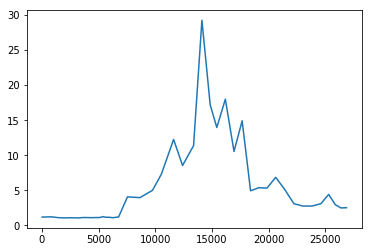

In [179]:

plt.plot(df_group.loc[df_group['Скважина'] == wells_prod[0], 'liq_cum'], 
         df_group.loc[df_group['Скважина'] == wells_prod[0], 'liq_rate']/df_group.loc[df_group['Скважина'] == wells_prod[0], 'oil_rate'])

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


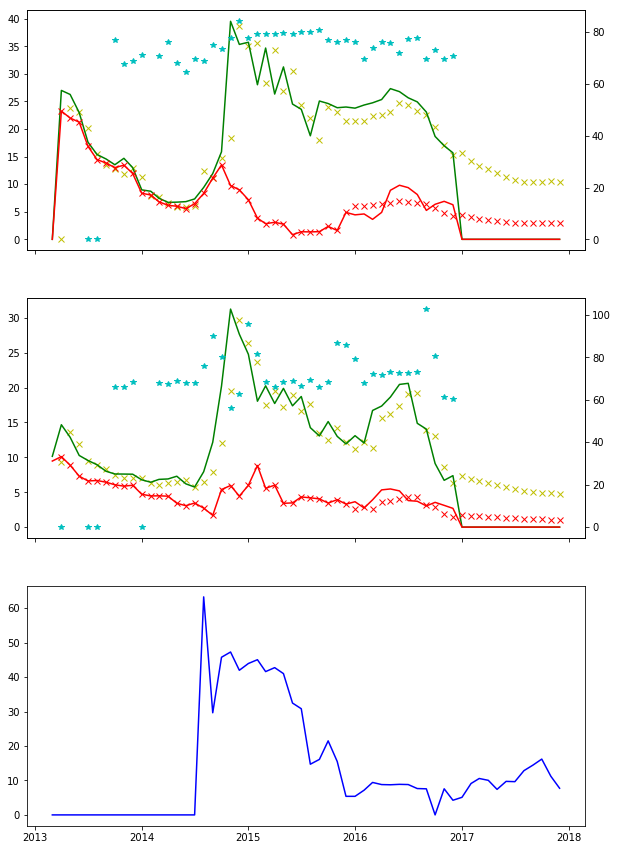

In [204]:
idx = pd.IndexSlice
wells = df_group['Скважина'].unique().tolist()
group=gr
fig, ax = plt.subplots(nrows=len(wells), ncols=1, figsize=(10, len(wells)*5), sharex=True) 
for j, well in enumerate(wells):
    if well in wells_prod:
        ax[j].plot(df_Qt_pred_seq[well], 'x', color='y', label='liq_pred')
        ax[j].plot(df_liq_rate[well], color='g', label=o'liq_target')
        ax[j].plot(df_oil_rate[well], color='r', label='oil_target')
        ax[j].plot(df_Qoil_pred[well], 'x', color='r', label='oil_pred')
        ax1 = ax[j].twinx()
        ax1.plot(df_test_b_ind.loc[idx[group, well], 'Забойное давление'], '*', color='c', label='bhp')
        #ax1.plot(df_group.loc[df_group['Скважина'] == well, 'Дата'], df_group.loc[df_group['Скважина'] == well, 'oil_cum'], '*', color='c', label='oil_cum')
    if well in wells_inj:
        ax[j].plot(df_inj_rate[well], color='b', label='inj')

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


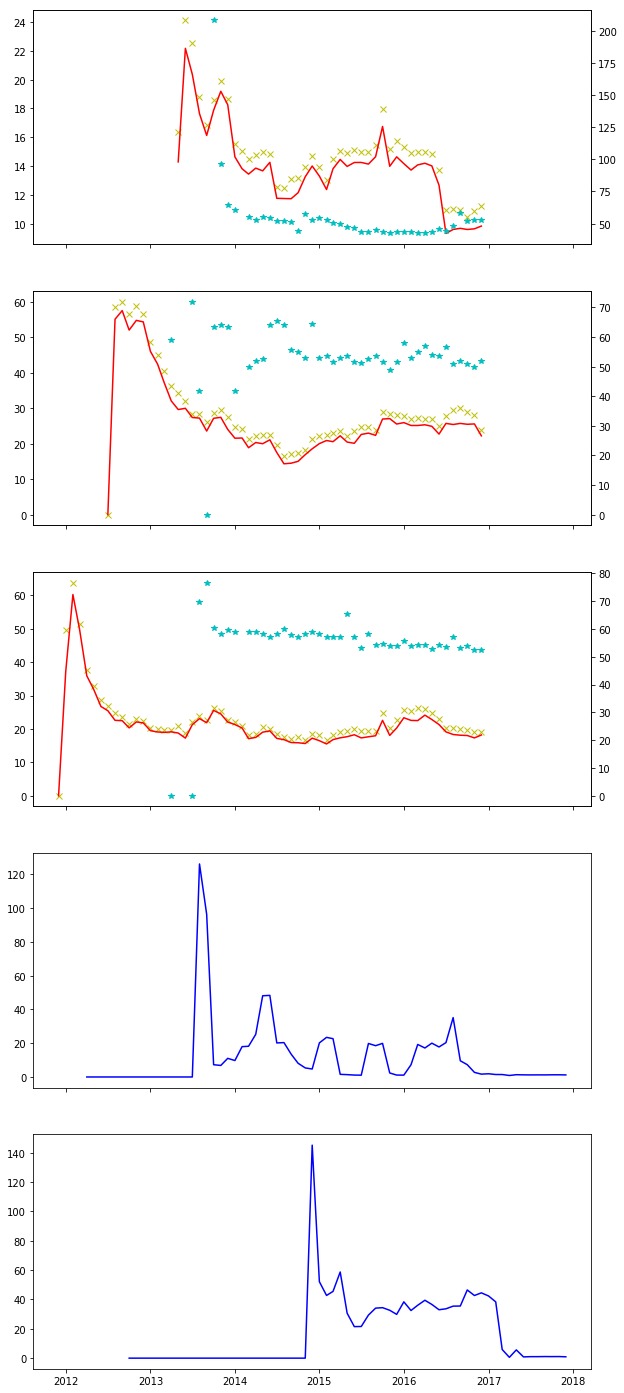

In [148]:
idx = pd.IndexSlice
wells = df_group['Скважина'].unique().tolist()
group=gr
fig, ax = plt.subplots(nrows=len(wells), ncols=1, figsize=(10, len(wells)*5), sharex=True) 
for j, well in enumerate(wells):
    if well in wells_prod:
        ax[j].plot(df_group.loc[df_group['Скважина'] == well, 'Дата'],
                   df_group.loc[df_group['Скважина'] == well, 'liq_rate'], 'x', color='y', label='liq')
        #ax[j].plot(df_liq_rate[well], color='g', label='liq_target')
        ax[j].plot(df_group.loc[df_group['Скважина'] == well, 'Дата'],
                   df_group.loc[df_group['Скважина'] == well, 'oil_rate'], color='r', label='oil_target')
        #ax[j].plot(df_Qoil_pred[well], 'x', color='r', label='oil_pred')
        ax1 = ax[j].twinx()
        ax1.plot(df_test_b_ind.loc[idx[group, well], 'Забойное давление'], '*', color='c', label='bhp')
        #ax1.plot(df_group.loc[df_group['Скважина'] == well, 'Дата'], df_group.loc[df_group['Скважина'] == well, 'oil_cum'], '*', color='c', label='oil_cum')
    if well in wells_inj:
        ax[j].plot(df_group.loc[df_group['Скважина'] == well, 'Дата'],
                   df_group.loc[df_group['Скважина'] == well, 'inj_rate'], color='b', label='inj')

### В каждой группе 3-6 добываюших скважин и как правило 1-2 нагнетательные
Ниже карты взаимного расположения скважин из одной группы из тест и трейн сета

In [ ]:
idx = pd.IndexSlice

In [272]:
def plot_group_test(group):
    wells = df_test_b_ind.loc[group].index.get_level_values(0).unique()
    fig, ax = plt.subplots(nrows=len(wells), ncols=1, figsize=(10, len(wells)*6), sharex=True) 
    for j, well in enumerate(wells):
        df_test_b_ind.loc[idx[group, well, :]].plot(x= 'Дата', y= ['Жидкость, м3', 'Нефть, м3', 'Закачка, м3'], ax=ax[j]);
        if any(df_test_b_ind.loc[idx[group, well, :], 'Характер работы'].isin(['НАГ'])) & any(df_test_a_ind['Скважина'].isin([well])):
            df_test_a_ind.loc[idx[group, well, :]].plot(x='Дата', y =['Закачка, м3'], ax=ax[j]);
            
def plot_group_train(group):
    wells = df_train_ind.loc[group].index.get_level_values(0).unique()
    fig, ax = plt.subplots(nrows=len(wells), ncols=1, figsize=(10, len(wells)*6), sharex=True) 
    for j, well in enumerate(wells):
        df_train_ind.loc[idx[group, well, :]].plot(x= 'Дата', y= ['Жидкость, м3', 'Нефть, м3', 'Закачка, м3'], ax=ax[j]);
        #if any(df_test_b_ind.loc[idx[group, well, :], 'Характер работы'].isin(['НАГ'])):
         #   df_test_a_ind.loc[idx[group, well, :]].plot(x='Дата', y =['Закачка, м3'], ax=ax[j]);

### Пример как выглядит объединенные ряды test_before и test_after
Тест:

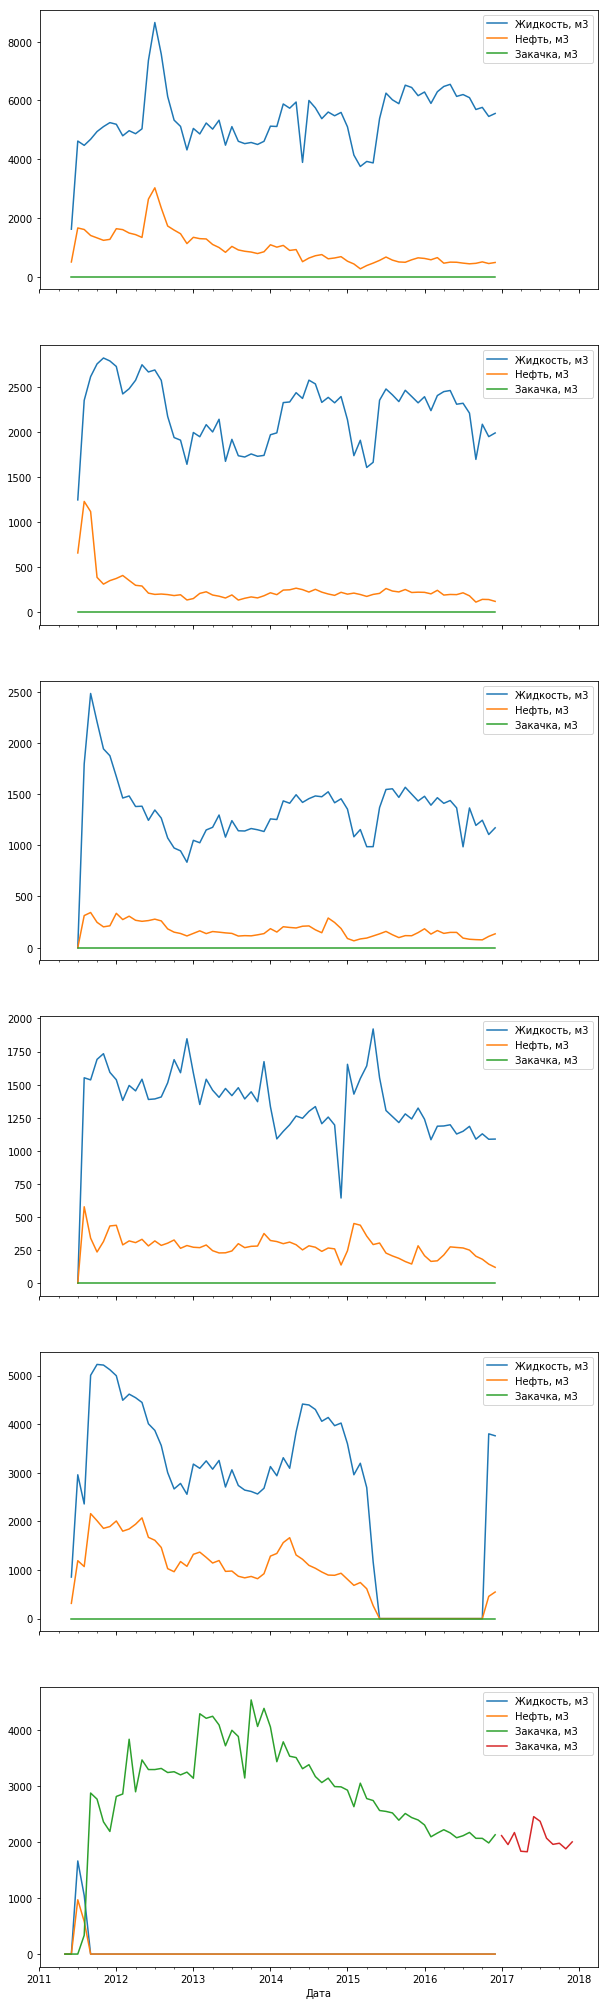

In [273]:
plot_group_test(43)

Трейн:

In [ ]:
plot_group_train(groups_train[10])